In [0]:
!wget https://raw.githubusercontent.com/CW-Huang/IFT6135H19_assignment/master/assignment3/samplers.py

--2019-04-22 20:54:32--  https://raw.githubusercontent.com/CW-Huang/IFT6135H19_assignment/master/assignment3/samplers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 888 [text/plain]
Saving to: ‘samplers.py.1’

samplers.py.1       100%[===================>]     888  --.-KB/s    in 0s      

2019-04-22 20:54:32 (163 MB/s) - ‘samplers.py.1’ saved [888/888]



In [0]:
from samplers import distribution1,distribution2,distribution3,distribution4

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [0]:
import numpy as np
import datetime
import os, sys

In [0]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class Discriminator_JS(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator_JS, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(0.2),
            #nn.Linear(32, 16),
            #nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [0]:
#Loss function
def JSD(Dx, Dy):
  jsd = torch.log(torch.tensor(2.)) + (1/2)*torch.mean(torch.log(Dx)) + (1/2)*torch.mean(torch.log(1-Dy))
  jsd=jsd.to(device)
  return -jsd



In [0]:
def init_weights_JS(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

**part 1.1**

In [0]:
#Train loop
batch_size = 512
loss_JSD = []
criterion=JSD

#for epoch in range(10):
for j in range(-10, 11):
  D_JS = Discriminator_JS().to(device)
  D_JS_opt= torch.optim.Adam(D_JS.parameters(), lr=0.001)

  #D_JS_opt= torch.optim.SGD(D_JS.parameters(), lr=0.001)#torch.optim.Adam(D_JS.parameters(), lr=1e-3, betas=(0.5, 0.999))
  D_JS.apply(init_weights_JS)
  
  for idx in range(5*1000):
    #(x,y)=next(iter(zip(data1,data2)))  
    x = next(iter(distribution1(0, batch_size=512)))
    y = next(iter(distribution1(j/10, batch_size=512)))
    
    x=torch.from_numpy(x)
    x=x.float()
    x=x.to(device)
    y=torch.from_numpy(y)
    y=y.float()
    y=y.to(device)


    Dx = D_JS(x)
    Dy = D_JS(y)
    loss = criterion(Dx, Dy)
    loss.to(device)

    
    loss.backward()
    D_JS_opt.step()
    D_JS_opt.zero_grad()
  loss_JSD.append(-loss.item())
  print('loss:',-loss.item())

loss: 0.6931391954421997
loss: 0.6931424140930176
loss: 0.6931426525115967
loss: 0.6931368112564087
loss: 0.6931414008140564
loss: 0.6931409239768982
loss: 0.6931359171867371
loss: 0.6931366324424744
loss: 0.6931369304656982
loss: 0.693131685256958
loss: -1.1086463928222656e-05
loss: 0.6931231021881104
loss: 0.69313645362854
loss: 0.6931360960006714
loss: 0.6931366920471191
loss: 0.6931400895118713
loss: 0.6931384205818176
loss: 0.6931402683258057
loss: 0.6931339502334595
loss: 0.6931408047676086
loss: 0.6931447982788086


**Part 1.2**

In [0]:
# loss function
def WD(Dx, Dy, dz, lambda_=10):
    wd = torch.mean(Dx) - torch.mean(Dy) - lambda_*torch.mean((torch.norm(dz, dim=1)-1)**2)
    return -wd

In [0]:
def init_weights_WD(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

In [0]:
class Discriminator_WD(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=2, num_classes=1):
        super(Discriminator_WD, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(0.2),
            #nn.Linear(512, 256),
            #nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, num_classes),
            #nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [0]:
#Train loop
loss_WD = []
criterion=WD
#for epoch in range(10):
for j in range(-10,11):
  batch_size = 512
  D_WD = Discriminator_WD().to(device)
  D_WD_opt =torch.optim.Adam(D_WD.parameters(), lr=0.001)# torch.optim.RMSprop(D_WD.parameters(), lr=1e-5)
  D_WD.apply(init_weights_WD)
  
  for idx in range(5*1000):
    #(x,y)=next(iter(zip(data1,data2)))
    x =next(iter(distribution1(0, batch_size=512)))
    y =next(iter(distribution1(j/10, batch_size=512)))
    a =next(iter(distribution2(batch_size=512)))
    a.size 
        
    x=torch.from_numpy(x)
    x=x.float()
    x=x.to(device)
    y=torch.from_numpy(y)
    y=y.float()
    y=y.to(device)
    a=torch.from_numpy(a)
    a=a.float()
    a=a.to(device)



    Dx = D_WD(x)
    Dy = D_WD(y)
    
    z = a*x + (1-a)*y
    z.retain_grad()
    z.requires_grad = True
    Dz = D_WD(z)

    
    dz = torch.autograd.grad(Dz, z, grad_outputs=torch.ones_like(Dz), create_graph=True, retain_graph=True)[0]
    loss = criterion(Dx, Dy, dz)
    
    #if idx % 1000 == 0:
    #  print(loss.item())

    loss.backward()
    D_WD_opt.step()
    #for ii in D_WD.parameters():
    #  ii.data.clamp_(-0.01, 0.01)
    D_WD_opt.zero_grad()
  loss_WD.append(-loss.item()) 
  print('loss:',-loss.item())   

loss: 1.0254312753677368
loss: 0.9204578995704651
loss: 0.8161530494689941
loss: 0.7123019695281982
loss: 0.6091760993003845
loss: 0.5054112672805786
loss: 0.4044192135334015
loss: 0.3022436499595642
loss: 0.20054258406162262
loss: 0.10022018104791641
loss: -0.005370713770389557
loss: 0.10002093762159348
loss: 0.20111893117427826
loss: 0.3022443950176239
loss: 0.4039749205112457
loss: 0.5063872933387756
loss: 0.6087861657142639
loss: 0.7121270895004272
loss: 0.8160949945449829
loss: 0.9216030240058899
loss: 1.024813175201416


**Part 1-3**



In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/ift6135_A3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


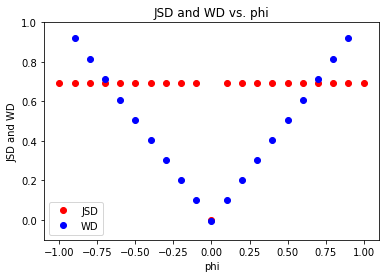

In [0]:
plt.figure()
plt.plot([j/10 for j in range(-10,11)],loss_JSD,'ro',[j/10 for j in range(-10,11)],loss_WD, 'bo')
plt.axis([-1.1, 1.1, -0.1, 1])
plt.xlabel('phi')
plt.ylabel('JSD and WD')
plt.title('JSD and WD vs. phi')
plt.legend(('JSD','WD'))
plt.savefig(path+'jsd_gan_est.png')
plt.show()


**Part 1-4**

In [0]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

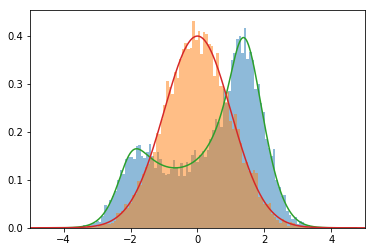

In [0]:
# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))

In [0]:
############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
 
#Train loop
criterion=JSD


D_JS = Discriminator_JS(input_size=1).to(device)
D_JS_opt= torch.optim.Adam(D_JS.parameters(), lr=0.001)
#D_JS_opt= torch.optim.SGD(D_JS.parameters(), lr=0.001)
D_JS.apply(init_weights_JS)
  
for idx in range(7*1000):
  #(x,y)=next(iter(zip(data1,data2)))  
  x = next(iter(distribution4(batch_size=512)))
  y = next(iter(distribution3(batch_size=512)))
    
  x=torch.from_numpy(x)
  x=x.float()
  x=x.to(device)
  y=torch.from_numpy(y)
  y=y.float()
  y=y.to(device)


  Dx = D_JS(x)
  Dy = D_JS(y)
  
  loss = criterion(Dx, Dy)
  loss.to(device)

    

  loss.backward()
  D_JS_opt.step()
  D_JS_opt.zero_grad()


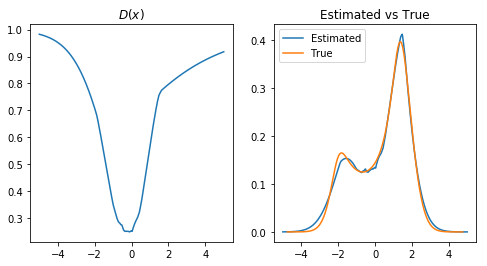

In [0]:
############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density

r = D_JS(torch.from_numpy(xx).float().reshape((-1,1))).reshape(-1).detach().numpy() # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = ((1/np.sqrt(2*np.pi)) * (np.e ** (-(xx**2)/2))) * r / (1 - r) # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
plt.savefig(path+'q14.png')